In [2]:
#IMPORTATION DE MODULES
#from textblob import TextBlob
import json
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


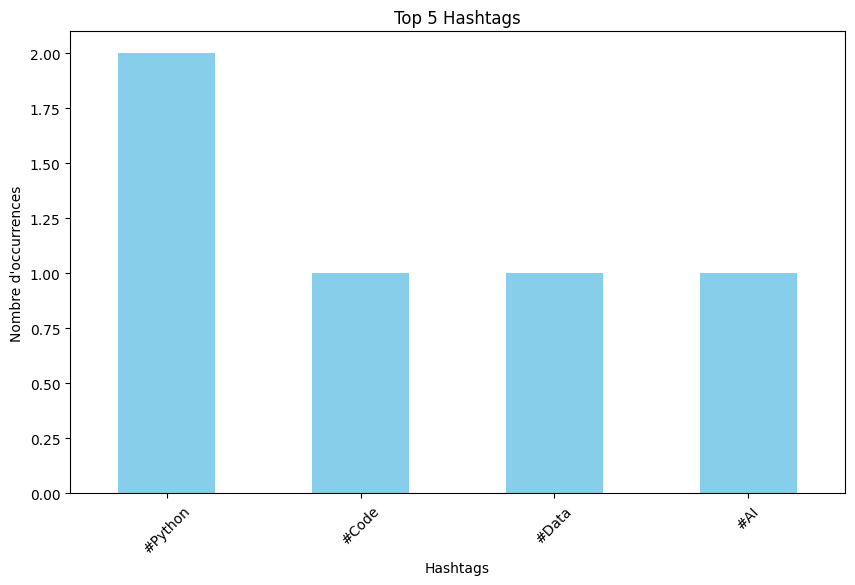

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de données
data = {
    "hashtags": [["#Python", "#Code"], ["#Data"], ["#Python", "#AI"]]
}
df = pd.DataFrame(data)

# Exploser les hashtags
hashtags = df["hashtags"].explode()

# Compter les occurrences des hashtags
top_hashtags = hashtags.value_counts().head(5)

# Visualiser avec un bar chart
plt.figure(figsize=(10, 6))
top_hashtags.plot(kind="bar", color="skyblue")
plt.title("Top 5 Hashtags")
plt.xlabel("Hashtags")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.show()


In [13]:
# Télécharger les stopwords en français si ce n'est pas déjà fait
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')




[nltk_data] Downloading package stopwords to /Users/jesse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jesse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jesse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
#PARTIE : CREATION DU TWEET + SOUMISSION DU TWEET DANS LANDING ZONE

#Création d'une Classe Tweet à laquelle seront associées les attributs suivant : auteurs, hashtag, mentions, sentiments, (topics???)

class Tweet: #Plan/Modèle
    def __init__(self, contenu): #Méthode (assisstant qui aide à donner à chaque tweet ses attributs)
        self.contenu = contenu

    def Nettoyage_Tweet(self):
        """Fonction qui supprime les caractères spéciaux d'un tweet"""
        enlever_speciaux = re.sub(r'[^a-zA-Z0-9\s@#]', '', self.contenu)
        return enlever_speciaux

class ZA:
    def __init__(self, id, auteur, texte): #Méthode (assisstant qui aide à donner à chaque tweet ses attributs)
        self.id = id
        self.auteur = auteur
        self.text = texte
        self.hashtags = self.Extraction_Hashtags()
        self.mentions = self.Extraction_Mentions()
        self.sentiment = self.Extraction_Sentiments()

    
    def Extraction_Sentiments(self): 
        """Extrait le sentiment du texte"""
        blob = TextBlob(self.text)
        polarite =  blob.sentiment.polarity
        if polarite > 0:
            sentiment = 'positif'
        elif polarite < 0:
            sentiment = 'négatif'
        elif polarite == 0:
            sentiment = 'neutre'
        return sentiment
    
    def Extraction_Hashtags(self):  #A Faire 
        """"""
        hashtags = re.findall(r'#\w+', self.text)
        return hashtags
    
    def Extraction_Mentions(self):  #A Faire
        """Fonction qui extrait les mentions de personnes dans un tweet"""
        mentions = re.findall(r'@[A-Za-z0-9_]+', self.text)

        return mentions


    def Id_Topic(tweet):

        def traitement_texte(text):
            text= text.lower() # mettre en minuscule
            text= re.sub(r'[^a-z\s]', '', text) 
            return text
        def get_stopwords():
            return stopwords.words('french')
        stopwords_list = get_stopwords()
        tweets= []
        with open ('ZA.json','r',encoding='utf-8') as f:
            donnee= json.load(f)
        
        tweets = [infos["tweet"] for infos in donnee]
        
        texte_traite = [traitement_texte(tweet) for tweet in tweets]
        
        vecteur = TfidfVectorizer(stop_words= stopwords_list)  # Utilise les stopwords en français intégrés dans sklearn
        a = vecteur.fit_transform(texte_traite)

        # n_components=2 : Le modèle cherchera à identifier 2 sujets principaux dans les données textuelles.
        lda = LatentDirichletAllocation(n_components=2, random_state=42)
        lda.fit(a) # on utilise LDA sur la matrice X 

        topics = []
        # Récupération du vocabulaire extrait par TfidfVectorizer
        words = vecteur.get_feature_names_out()
        for i, topic_weights in enumerate(lda.components_):
            top_indices = topic_weights.argsort()[:-3:-1]  # Prendre les 2 mots les plus importants
            top_words = [words[i] for i in top_indices]  # Utilisation des indices pour récupérer les mots correspondants dans la liste `words`.

            topics.append(f": {', '.join(top_words)}")

        tweet_traite = traitement_texte(tweet)
        vecteur = TfidfVectorizer(stop_words= stopwords_list) # Utilise les stopwords en français intégrés dans sklearn
        vecteur_tweet= vecteur.transform([tweet_traite]) 
        probabilities = lda.transform(vecteur_tweet)
        topic = probabilities.argmax()  # Trouve l'indice du topic avec la probabilité la plus élevée

        print(f"Le tweet :\n{tweet}\nAppartient au Topic {topics[topic]}")


def Zone_Atterisssage (Fichier): # incomplet
        """Stockage du tweet dans le fichier json zone d'atterissage"""
        ZA_liste=[]
        
        with open (Fichier,'r',encoding='utf-8') as f:
            donnee= json.load(f)
            
        for infos_tweets in donnee:
            id = infos_tweets.get("id")
            auteur = infos_tweets.get("author_id")
            contenu = infos_tweets.get("text")

            tweet = Tweet(contenu)
            contenu_nettoye = tweet.Nettoyage_Tweet()
    

            tweet_analyse = ZA(id, auteur, contenu_nettoye)


            dict_tweet = {
                "id": tweet_analyse.id,
                "auteur": tweet_analyse.auteur,
                "tweet": contenu_nettoye,
                "texte": tweet_analyse.text,
                "hashtags" : tweet_analyse.hashtags,
                "mentions" : tweet_analyse.mentions,
                "sentiment" : tweet_analyse.sentiment
            }


            ZA_liste.append(dict_tweet)

        
        
        with open('ZA.json','w', encoding='utf-8') as f:
            json.dump(ZA_liste, f, indent=4, ensure_ascii=False)
        
Zone_Atterisssage('/Users/jesse/Desktop/Projet/Projets/Projet final/versailles_tweets_100.json')



# --> il faut charger ces données dans une date frame : df = pd.DataFrame(tweets)





In [ ]:
#DATAFRAME
def CreerDataFrame(fichier_json):
    df  = pd.read_json(fichier_json)
    return df

#Analyses avancées 

def Top_K_element(df, colonne, k=3):
    """
    Retourne les K éléments les plus fréquents dans une colonne donnée.
    """
    return df[colonne].explode().value_counts().head(k) #a méthode .explode() transforme chaque élément d'une liste dans une ligne distincte.

def publications_par_hashtag(df):
    """
    Retourne le nombre de publications par hashtag.
    """
    hashtags_explodes = df['hashtags'].explode()
    return hashtags_explodes.value_counts()

def publications_par_utilisateurs(df):
    """
    Retourne le nombre de publications par utilisateur.
    """
    return df['auteur'].value_counts()

def publications_par_topic(df):
    """
    Retourne le nombre de publications par topics.
    """
    return df['topics'].value_counts()

def tweets_par_utilisateur(df,utilisateur):
    """
    Retourne le nombre de publications par topics.
    """
    filtre = df[df['auteur'] == utilisateur]
    return filtre
    
def ensemble_de_tweets_mentionnant_utilisateur(df,utilisateur_mentionné):
    """
    Retourne le nombre de publications par topics.
    """
    filtre = df[df['mentions'] == utilisateur_mentionné]
    return filtre

def ensemble_de_utilisateurs_mentions_hashtag(df, hashtag):
    """
    Retourne le nombre de publications par topics.
    """
    filtre = df[df['hashtag'] == hashtag]
    return filtre
    
def ensemble_de_utilisateurs_mentionnés_utilisateur(df, utilisateur):
    """
    Retourne les mentions d'un utilisateur.
    """
    tweets_u = df[df['auteur'] == utilisateur]
    mentions = tweets_u['mentions'].explode()
    return list(mentions)


#Visualisation des résultats 



hashtags
#CIV                2
#twitter225         1
#SupportriceMazo    1
#domie              1
#jifa               1
#versailles         1
#nocturne           1
#appollon           1
Name: count, dtype: int64

In [3]:
import gradio as gr
import pandas as pd

def process_file(file, sentiment_filter):
    """
    Charge un fichier JSON, filtre par sentiment, et retourne les résultats.
    """
    # Charger le fichier JSON dans un DataFrame
    data = pd.read_json(file.name)
    
    # Filtrer les données si un sentiment est sélectionné
    if sentiment_filter != "Tous":
        data = data[data["sentiment"] == sentiment_filter]
    
    # Retourner les données filtrées
    return data

def export_csv(file, sentiment_filter):
    """
    Exporter les données filtrées en CSV.
    """
    data = pd.read_json(file.name)
    
    if sentiment_filter != "Tous":
        data = data[data["sentiment"] == sentiment_filter]
    
    # Sauvegarder en fichier CSV temporaire
    csv_file = "filtered_tweets.csv"
    data.to_csv(csv_file, index=False)
    return csv_file

# Interface Gradio
with gr.Blocks() as app:
    gr.Markdown("## Gestion des Tweets JSON")
    
    # Uploader le fichier JSON
    file_input = gr.File(label="Charger un fichier JSON")
    
    # Sélectionner le filtre de sentiment
    sentiment_filter = gr.Dropdown(["Tous", "positif", "neutre", "négatif"], label="Filtrer par Sentiment")
    
    # Bouton pour afficher les données
    show_data_button = gr.Button("Afficher les Données")
    
    # Table pour afficher les résultats
    data_table = gr.DataFrame(headers=["id", "auteur", "contenu", "hashtags", "mentions", "sentiment"], label="Résultats")
    
    # Bouton pour télécharger les résultats filtrés
    export_button = gr.Button("Télécharger les Résultats")
    file_download = gr.File(label="Fichier Téléchargeable")

    # Actions sur les boutons
    show_data_button.click(process_file, inputs=[file_input, sentiment_filter], outputs=data_table)
    export_button.click(export_csv, inputs=[file_input, sentiment_filter], outputs=file_download)

# Lancer l'application
if __name__ == "__main__":
    app.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [4]:
import re
import json
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

class Tweet:
    def __init__(self, id, auteur, contenu):
        self.id = id
        self.auteur = auteur
        self.contenu = contenu
        self.contenu_nettoye = self.Nettoyage_Tweet()
        self.hashtags = self.Extraction_Hashtags()
        self.mentions = self.Extraction_Mentions()
        self.sentiment = self.Extraction_Sentiments()

    def Nettoyage_Tweet(self):
        """Supprime les caractères spéciaux d'un tweet"""
        return re.sub(r'[^a-zA-Z0-9\s@#]', '', self.contenu)

    def Extraction_Hashtags(self):
        return re.findall(r'#\w+', self.contenu)

    def Extraction_Mentions(self):
        return re.findall(r'@[A-Za-z0-9_]+', self.contenu)

    def Extraction_Sentiments(self):
        blob = TextBlob(self.contenu)
        polarite = blob.sentiment.polarity
        if polarite > 0:
            return 'positif'
        elif polarite < 0:
            return 'négatif'
        else:
            return 'neutre'

    def to_dict(self):
        """Convertit l'objet Tweet en dictionnaire."""
        return {
            'id': self.id,
            'auteur': self.auteur,
            'contenu': self.contenu,
            'contenu_nettoye': self.contenu_nettoye,
            'hashtags': self.hashtags,
            'mentions': self.mentions,
            'sentiment': self.sentiment
        }

class ZA:
    def __init__(self, chemin_fichier):
        self.chemin_fichier = chemin_fichier
        self.tweets_data = []  

    def charger_tweets(self):
        """Charge les tweets depuis le fichier JSON et extrait les informations."""
        with open(self.chemin_fichier, 'r', encoding='utf-8') as f:
            donnee = json.load(f)
        
        for infos_tweets in donnee:
            tweet = Tweet(
                infos_tweets.get("id"),
                infos_tweets.get("author_id"),
                infos_tweets.get("text")
            )
            # Ajoute le dictionnaire du tweet à la liste
            self.tweets_data.append(tweet.to_dict())
        
        # Convertir en DataFrame pour une utilisation ultérieure
        df = pd.DataFrame(self.tweets_data)
        
        # Sauvegarder dans un fichier JSON si nécessaire
        with open('ZA.json', 'w', encoding='utf-8') as f:
            json.dump(self.tweets_data, f, indent=4, ensure_ascii=False)
        
        return df

# Exemple d'utilisation de la classe ZA
za = ZA('versailles_tweets_100.json')
df_tweets = za.charger_tweets()
print(df_tweets.head())

                    id               auteur  \
0  1421616335700824064  1339914264522461187   
1  1421599703116943360  1339914264522461187   
2  1421599163561742339  1339914264522461187   
3  1421591889095057416  1339914264522461187   
4  1421582795294617605            717025418   

                                             contenu  \
0  Goumin des éléphants joueurs la même fatigue m...   
1  @ericbailly24 @maxigr04del  mes tontons vous a...   
2  Ah oui le sommeil là sera compliqué. #CIV  est...   
3  31 juillet , journée internationale de la femm...   
4           Le pedigree 😂😂😂😂 https://t.co/D3Rv7A2BOF   

                                     contenu_nettoye  \
0  Goumin des lphants joueurs la mme fatigue mme ...   
1  @ericbailly24 @maxigr04del  mes tontons vous a...   
2  Ah oui le sommeil l sera compliqu #CIV  est li...   
3  31 juillet  journe internationale de la femme ...   
4                    Le pedigree  httpstcoD3Rv7A2BOF   

                           hashtags        

Traceback (most recent call last):
  File "/Users/jesse/miniconda3/lib/python3.11/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jesse/miniconda3/lib/python3.11/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jesse/miniconda3/lib/python3.11/site-packages/gradio/blocks.py", line 2015, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jesse/miniconda3/lib/python3.11/site-packages/gradio/blocks.py", line 1562, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jesse/miniconda3/lib/python3.11/site-packages/anyio/to_thread.py", line 56, in run_sync
    return awai

--> Pour améliorer ce code il faudrait utiliser nltk pour la tokenisation et la lemmenisation : ça va couper les tweet en petit mots et reduire les mots en leur forme conique ( je n'arrive pas à utilser nltk pour faire ça, erreur)

Ducoup la c pas précis

In [ ]:
t= "@ericbailly24 @maxigr04del  mes tontons vous avez fait votre part , JO prochain on ira en demi final au moins. BRAVO à vous . #SupportriceMazo #domie #CIV"


def Nettoyage_Tweet(tweet):
    """Fonction qui supprime les caractères spéciaux d'un tweet"""
    enlever_speciaux = re.sub(r'[^a-zA-Z0-9\s@#]', '', tweet)
    return enlever_speciaux

def Extraction_Sentiments(tweet): 
        """Extrait le sentiment du texte"""
        blob = TextBlob(tweet)
        polarite =  blob.sentiment.polarity
        if polarite > 0:
            sentiment = 'positif'
        elif polarite < 0:
            sentiment = 'négatif'
        elif polarite == 0:
            sentiment = 'neutre'
        return sentiment
    
def Extraction_Hashtags(tweet):  #A Faire 
        """"""
        hashtags = re.findall(r'#\w+', tweet)
        return hashtags
    
def Extraction_Mentions(tweet):  #A Faire
        """Fonction qui extrait les mentions de personnes dans un tweet"""
        mentions = re.findall(r'@[A-Za-z0-9_]+', tweet)
        return mentions


print(Nettoyage_Tweet(t))
print(Extraction_Sentiments(t))
print(Extraction_Hashtags(t))
print(Extraction_Mentions(t))




@ericbailly24 @maxigr04del  mes tontons vous avez fait votre part  JO prochain on ira en demi final au moins BRAVO  vous  #SupportriceMazo #domie #CIV
neutre
['#SupportriceMazo', '#domie', '#CIV']
['@ericbailly24', '@maxigr04del']


In [ ]:
donne= [
    {"tweet": "Le réchauffement climatique menace la biodiversité."},
    {"tweet": "La pollution des océans est un problème mondial."},
    {"tweet": "Les voitures électriques sont une solution écologique."},
    {"tweet": "Les panneaux solaires deviennent plus efficaces chaque année."},
    {"tweet": "La déforestation accélère le changement climatique."}
]


def Id_Topic(tweet):

    def traitement_texte(text):
        text= text.lower() # mettre en minuscule
        text= re.sub(r'[^a-z\s]', '', text) 
        return text
    def get_stopwords():
        return stopwords.words('french')
    stopwords_list = get_stopwords()
    tweets= []
    
        
    tweets = [infos["tweet"] for infos in donne]
        
    texte_traite = [traitement_texte(tweet) for tweet in tweets]
        
    vecteur = TfidfVectorizer(stop_words= stopwords_list)  # Utilise les stopwords en français intégrés dans sklearn
    a = vecteur.fit_transform(texte_traite)

    # n_components=2 : Le modèle cherchera à identifier 2 sujets principaux dans les données textuelles.
    lda = LatentDirichletAllocation(n_components=2, random_state=42)
    lda.fit(a) # on utilise LDA sur la matrice X 

    topics = []
    # Récupération du vocabulaire extrait par TfidfVectorizer
    words = vecteur.get_feature_names_out()
    for i, topic_weights in enumerate(lda.components_):
        top_indices = topic_weights.argsort()[:-3:-1]  # Prendre les 2 mots les plus importants
        top_words = [words[i] for i in top_indices]  # Utilisation des indices pour récupérer les mots correspondants dans la liste `words`.

        topics.append(f": {', '.join(top_words)}")

    tweet_traite = traitement_texte(tweet)
    vecteur_tweet= vecteur.transform([tweet_traite]) 
    probabilities = lda.transform(vecteur_tweet)
    topic = probabilities.argmax()  # Trouve l'indice du topic avec la probabilité la plus élevée

    print(f"Le tweet :\n{tweet}\nAppartient au Topic {topics[topic]}")

tweet = "Le réchauffement climatique menace la biodiversité."
Id_Topic(tweet)


Le tweet :
Le réchauffement climatique menace la biodiversité.
Appartient au Topic : biodiversit, rchauffement
